Initial population 2
Final population sideband cooling: 0.9012295078582434
Y = 1.9964060123183491 * e^(-1.3282216271595844e-06 * x) + -0.002307604318391001; expected rate 2.0000000000000004e-07
Y = 0.6534404375939522 * e^(-1.3610829978421304e-05 * x) + 1.3222136491919292; expected rate 1e-05
R² = 0.9999999892873445
R² = 0.9889559906212513


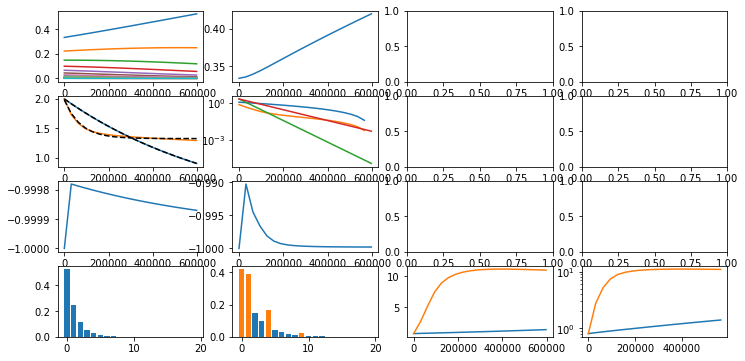

In [3]:
# Simulation of sideband cooling and trapped states

import numpy as np
import matplotlib.pyplot as plt
import time as time
from scipy.linalg import expm
import scipy.optimize

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

D=1
nu=1
eta=.02
Omega=.01
G=1000
ni=2
b=-np.log(ni/(ni+1))

print(f"Initial population {ni}")


nmax = 20
n0 = 1
tau = 2*np.pi/(Omega*eta*np.sqrt(n0))
tg = 2/G
dt = tau + tg
tsteps = 20

# operators
sz = np.array([[1,0j],[0j,-1]])
sx = np.array([[0j,1],[1,0j]])
sy = np.array([[0j,1j],[-1j,0j]])
Id = np.array([[1,0j],[-0j,1]])
Idn = np.eye(nmax)
sm = np.array([[0,0],[1,0j]])
a = np.diag(np.sqrt(np.arange(1,nmax)),1)
ad = np.transpose(a)
xop=a+ad
pop=a-ad
n = np.dot(ad,a)

#Liouvillian

#all order Hamiltonian
H = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)+Omega/2*(np.kron(expm(1j*eta*xop),sm)+np.kron(expm(-1j*eta*xop),sm.T))
#Lamb Dicke approximation
HLD = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(xop,sy)
#Jaynes Cummings approximation
HJC = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(ad,sm)+eta*Omega/2*np.kron(a,np.transpose(sm))
#decoupled Hamiltonian
H0 = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)

#spontaneous emission of the atom
D = np.kron(Idn,sm)
Dt = np.transpose(D)

ID = np.kron(Idn,Id)

#diffusion term of spontaneous emission
carrier=np.zeros(((nmax*2)**2,(nmax*2)**2),dtype=complex)
cosmax=100
cosal=np.arange(-cosmax,cosmax+1)/cosmax
W=3*(cosal**2+1)/4*1/2/cosmax
W=W/sum(W)
for i,c in enumerate(cosal):
    DD=np.kron(expm(1j*c*eta*xop),sm)
    carrier=carrier+W[i]*np.kron(DD,DD.conj()) #Spontaneous emission

#carrier=np.kron(D,D)

#trapped state lindbladians
#all-order coherent interaction
Lc = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H))
#reinitialization
Ld = -1j*np.kron(H0,ID) + 1j*np.kron(ID,np.transpose(H0)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling lindbladian
G=1.5*Omega
L = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling dynamical map
EL=expm(L*dt)
#trapped states dynamical map
ET=np.dot(expm(Ld*tg),expm(Lc*tau))

# tracer and rho0
rhoq=np.array([[0,0j],[0j,1]]) #State of qubit
rhon=expm(-b*nu*n)
rhon=rhon/np.trace(rhon)
rho0=np.kron(rhon,rhoq).reshape((nmax*2)**2,1)

tracer=np.kron(np.diag(Idn[:,0]),Id).reshape(1,(nmax*2)**2)
for i in np.arange(1,nmax):
    tracer=np.append(tracer,np.kron(np.diag(Idn[:,i]),Id).reshape(1,(nmax*2)**2),axis=0)

invtracer=np.kron(Idn,sz).reshape(1,(nmax*2)**2)

    
# State production
pn=np.zeros((nmax,tsteps),dtype=complex)
szt=np.zeros(tsteps,dtype=complex)
rho=rho0

pnT=np.zeros((nmax,tsteps),dtype=complex)
sztT=np.zeros(tsteps,dtype=complex)
QFI2=np.zeros((tsteps),dtype=complex)
QFI2T=np.zeros((tsteps),dtype=complex)
rhot=rho0

for i in np.arange(0,tsteps):
    pn[:,i:i+1]=np.dot(tracer,rho)
    szt[i]=np.dot(invtracer,rho)
    #rhosq=rho.reshape(nmax*2,nmax*2)
    #rhov=rhosq[::2,::2]+rhosq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhov)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rho=np.dot(EL,rho)
    
    pnT[:,i:i+1]=np.dot(tracer,rhot)
    sztT[i]=np.dot(invtracer,rhot)
    #rhotsq=rhot.reshape(nmax*2,nmax*2)
    #rhoTv=rhotsq[::2,::2]+rhotsq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhoTv)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2T[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rhot=np.dot(ET,rhot)

# Overlap as a function of displacement amplitude
almax=1000
dal=0.001
alpha=np.arange(0,almax)*dal
ov=np.zeros((nmax,almax),dtype=complex)
ovt=np.zeros((nmax,almax),dtype=complex)

#rhom=rho.reshape(nmax*2,nmax*2)
#rhotm=rhot.reshape(nmax*2,nmax*2)
#for i, al in enumerate(alpha):
#    d=expm(al*pop)
#    D=np.kron(d,Id)
#    Dt=D.conj().T
#    ov[:,i]=np.dot(tracer,np.dot(D,np.dot(rhom,Dt)).reshape((nmax*2)**2))
#    ovt[:,i]=np.dot(tracer,np.dot(D,np.dot(rhotm,Dt)).reshape((nmax*2)**2))

QFI=np.zeros((tsteps),dtype=complex)
QFIT=np.zeros((tsteps),dtype=complex)
dabs=np.abs(pop)**2
for j in np.arange(0,tsteps):
    v=np.kron(pn[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFI[j]=2*np.sum((v-h)**2/(v+h)*dabs)
    v=np.kron(pnT[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFIT[j]=2*np.sum((v-h)**2/(v+h)*dabs)



# Fisher information (it involves a numerical derivative and needs a very small dal)
#FI=np.diff(ov)**2/(ov[:,0:-1]-ov[:,0:-1]**2)/dal**2
#FIT=np.diff(ovt)**2/(ovt[:,0:-1]-ovt[:,0:-1]**2)/dal**2    


#Phonon number
nav=np.dot(np.diag(n),np.real(pn))
nTav=np.dot(np.diag(n),np.real(pnT))
ts= np.arange(0,tsteps)*dt
print(f"Final population sideband cooling: {nav[-1]}")

#Fitting
# perform the fit for population
p0 = (ni, eta**2*Omega/2, 0.01) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, ts, nav, p0)
m, t, b = params

p0T = (ni, eta*Omega/2*0.1, 4) # start with values near those we expect
paramsT, cvT = scipy.optimize.curve_fit(monoExp, ts, nTav, p0T)
mT, tT, bT = paramsT

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}; expected rate {eta**2*Omega/2*.1}")
print(f"Y = {mT} * e^(-{tT} * x) + {bT}; expected rate {eta*Omega/2*0.1}")

# determine quality of the fit
squaredDiffs = np.square(nav - monoExp(ts, m, t, b))
squaredDiffsFromMean = np.square(nav - np.mean(nav))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

squaredDiffsT = np.square(nTav - monoExp(ts, mT, tT, bT))
squaredDiffsFromMeanT = np.square(nTav - np.mean(nTav))
rSquaredT = 1 - np.sum(squaredDiffsT) / np.sum(squaredDiffsFromMeanT)
print(f"R² = {rSquaredT}")

# perform the fit for QFI
#QFI0 = (0, eta**2*Omega/2, 0.01) # start with values near those we expect
#paramsQ, cvQ = scipy.optimize.curve_fit(monoExp, ts, QFI, QFI0)
#mQ, tQ, bQ = paramsQ

#QFI0T = (0, eta*Omega/2*0.1, 4) # start with values near those we expect
#paramsQT, cvQT = scipy.optimize.curve_fit(monoExp, ts, QFIT, QFI0T)
#mQT, tQT, bQT = paramsQT

# inspect the parameters
#print(f"Y = {mQ} * e^(-{t} * x) + {bQ}; expected rate {eta**2*Omega/2}")
#print(f"Y = {mQT} * e^(-{t} * x) + {bQT}; expected rate {eta*Omega/2*0.13}")

# determine quality of the fit
#squaredDiffsQ = np.square(QFI - monoExp(ts, mQ, tQ, bQ))
#squaredDiffsFromMeanQ = np.square(QFI - np.mean(QFI))
#rSquaredQ = 1 - np.sum(squaredDiffsQ) / np.sum(squaredDiffsFromMeanQ)
#print(f"R² = {rSquaredQ}")

#squaredDiffsQT = np.square(QFIT - monoExp(ts, mQT, tQT, bQT))
#squaredDiffsFromMeanQT = np.square(QFIT - np.mean(QFIT))
#rSquaredQT = 1 - np.sum(squaredDiffsQT) / np.sum(squaredDiffsFromMeanQT)
#print(f"R² = {rSquaredQT}")


# Plotting    
fig, axes = plt.subplots(4, 4, figsize=(12,6))

for i in np.arange(0,nmax):
    axes[0,0].plot(np.arange(0,tsteps)*dt, np.real(pn[i,:]))

    #axes[1,2].plot(alpha, np.real(ov[i,:]))
    #axes[2,2].plot(alpha, np.real(ovt[i,:]))

    #axes[1,3].plot(alpha[0:-1], np.real(FI[i,:]))
    #axes[2,3].plot(alpha[0:-1], np.real(FIT[i,:]))


# This shows how much population is lost from the first trap as a function of time
axes[0,1].plot(np.arange(0,tsteps)*dt, np.real(0*pnT[1,:]+pnT[0,:]))


# overlap and FI of final state    
#axes[0,2].plot(alpha, np.real(ov[0,:]))
#axes[0,2].plot(alpha, np.real(ovt[1,:]))

#axes[0,3].plot(alpha[0:-1], np.real(FI[0,:]))
#axes[0,3].plot(alpha[0:-1], np.real(FIT[2,:]))


# Population decay as a function of time
axes[1,0].plot(ts, nav)
axes[1,0].plot(ts, nTav)
axes[1,0].plot(ts, monoExp(ts, m, t, b), 'k--', label="fitted")
axes[1,0].plot(ts, monoExp(ts, mT, tT, bT), 'k--', label="T fitted")

axes[1,1].set_yscale('log')

axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pn[:,:-1]))-np.dot(np.diag(n),np.real(pn[:,-1])))
axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pnT[:,:-1]))-np.dot(np.diag(n),np.real(pnT[:,-1])))
axes[1,1].plot(ts, monoExp(ts, ni, eta**2*Omega/2*10, 1)-1)
axes[1,1].plot(ts, monoExp(ts, ni, eta*Omega/2*0.1, 1)-1)

# Useful to check whether the carrier excitation is relevant. The closer to -1 the less carrier heating.
axes[2,0].plot(np.arange(0,tsteps)*dt, np.real(szt))
axes[2,1].plot(ts, np.real(sztT))

# (Initial) Final state
axes[3,0].bar(np.diag(n), np.real(pn[:,-1]))

axes[3,1].bar(np.diag(n), np.real(pnT[:,0]))
axes[3,1].bar(np.diag(n), np.real(pnT[:,-1]))

#PT=np.append(np.transpose([np.diag(n)]), np.transpose([np.real(pnT[:,-1])]),axis=1)
#print(PT)
#np.savetxt('simomega02.dat',PT)

#Time evolution of QFI
axes[3,2].plot(ts,np.real(QFI))
axes[3,2].plot(ts,np.real(QFIT))
#axes[3,2].plot(ts, monoExp(ts, mQ, tQ, bQ), '--', label="fitted")
#axes[3,2].plot(ts, monoExp(ts, mQT, tQT, bQT), '--', label="fitted")

axes[3,3].set_yscale('log')
tmax=tsteps
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFI[0:tmax-1]-0*QFI[tmax-1]))
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFIT[0:tmax-1]-0*np.max(QFIT)))



#QFItxt=np.append(np.transpose([np.arange(0,tmax-1)*dt]), np.transpose([np.real(QFIT[0:tmax-1])]),axis=1)
#QFItxt=np.append(QFItxt,np.transpose([np.real(QFI[0:tmax-1])]),axis=1)
#np.savetxt('QFITn04.dat',QFItxt)



#fig, axis = plt.subplots(1,1, figsize=(7,5))

#axis.plot(np.arange(0,tmax)*dt,4*np.ones(tmax),'k-.',label = 'SQL')


#for n0ind in np.arange(1,4):
#    QFIn0ind=np.loadtxt('QFITn0'+str(n0ind)+'.dat')
#    if n0ind==1:
#        axis.plot(QFIn0ind[:,0],QFIn0ind[:,2],label='Sideband Cooling')
#    axis.plot(QFIn0ind[:,0],QFIn0ind[:,1], label= r'Trapped state $n_0=$'+str(n0ind))

#axis.plot(np.arange(0,tmax-1)*dt,np.real(QFIT[0:tmax-1]-0*np.max(QFIT)), label= r'Trapped state $n_0=4$')

#axis.plot(dni*np.arange(0,nimax),0*np.ones(nimax),'k-')
#axis.legend()
#plt.xlabel(r'Time ($\nu^{-1}$)')
#plt.ylabel('QFI')
#plt.savefig("figure8.pdf", format="pdf", bbox_inches="tight")

plt.show()




Initial population 4
Final population sideband cooling: 1.1458663432064602
Y = 3.7735930103614894 * e^(-1.9877815501640894e-06 * x) + -0.006332490716471134; expected rate 2.0000000000000003e-06
Y = 1.0755756065424007 * e^(-1.1245522240485554e-05 * x) + 2.672509117317189; expected rate 1e-05
R² = 0.9999999547012615
R² = 0.9962784019874537


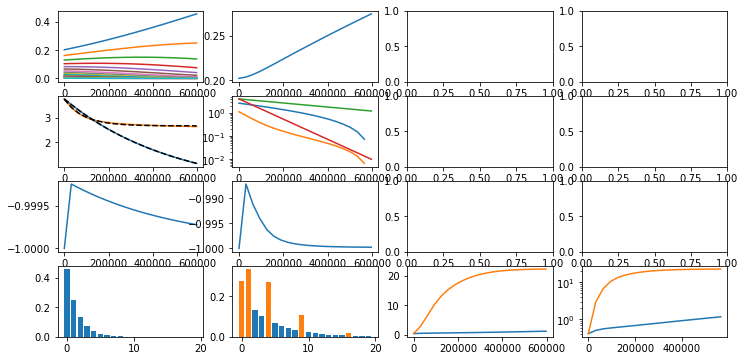

In [4]:
# Simulation of sideband cooling and trapped states
# Code to create n0=1 line of cooling rate

import numpy as np
import matplotlib.pyplot as plt
import time as time
from scipy.linalg import expm
import scipy.optimize

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

D=1
nu=1
eta=.02
Omega=.01
G=1000
ni=4
b=-np.log(ni/(ni+1))

print(f"Initial population {ni}")


nmax = 20
n0 = 1
tau = 2*np.pi/(Omega*eta*np.sqrt(n0))
tg = 2/G
dt = tau + tg
tsteps = 20

# operators
sz = np.array([[1,0j],[0j,-1]])
sx = np.array([[0j,1],[1,0j]])
sy = np.array([[0j,1j],[-1j,0j]])
Id = np.array([[1,0j],[-0j,1]])
Idn = np.eye(nmax)
sm = np.array([[0,0],[1,0j]])
a = np.diag(np.sqrt(np.arange(1,nmax)),1)
ad = np.transpose(a)
xop=a+ad
pop=a-ad
n = np.dot(ad,a)

#Liouvillian

#all order Hamiltonian
H = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)+Omega/2*(np.kron(expm(1j*eta*xop),sm)+np.kron(expm(-1j*eta*xop),sm.T))
#Lamb Dicke approximation
HLD = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(xop,sy)
#Jaynes Cummings approximation
HJC = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(ad,sm)+eta*Omega/2*np.kron(a,np.transpose(sm))
#decoupled Hamiltonian
H0 = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)

#spontaneous emission of the atom
D = np.kron(Idn,sm)
Dt = np.transpose(D)

ID = np.kron(Idn,Id)

#diffusion term of spontaneous emission
carrier=np.zeros(((nmax*2)**2,(nmax*2)**2),dtype=complex)
cosmax=100
cosal=np.arange(-cosmax,cosmax+1)/cosmax
W=3*(cosal**2+1)/4*1/2/cosmax
W=W/sum(W)
for i,c in enumerate(cosal):
    DD=np.kron(expm(1j*c*eta*xop),sm)
    carrier=carrier+W[i]*np.kron(DD,DD.conj()) #Spontaneous emission

#carrier=np.kron(D,D)

#trapped state lindbladians
#all-order coherent interaction
Lc = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H))
#reinitialization
Ld = -1j*np.kron(H0,ID) + 1j*np.kron(ID,np.transpose(H0)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling lindbladian
G=10*Omega
L = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling dynamical map
EL=expm(L*dt)
#trapped states dynamical map
ET=np.dot(expm(Ld*tg),expm(Lc*tau))

# tracer and rho0
rhoq=np.array([[0,0j],[0j,1]]) #State of qubit
rhon=expm(-b*nu*n)
rhon=rhon/np.trace(rhon)
rho0=np.kron(rhon,rhoq).reshape((nmax*2)**2,1)

tracer=np.kron(np.diag(Idn[:,0]),Id).reshape(1,(nmax*2)**2)
for i in np.arange(1,nmax):
    tracer=np.append(tracer,np.kron(np.diag(Idn[:,i]),Id).reshape(1,(nmax*2)**2),axis=0)

invtracer=np.kron(Idn,sz).reshape(1,(nmax*2)**2)

    
# State production
pn=np.zeros((nmax,tsteps),dtype=complex)
szt=np.zeros(tsteps,dtype=complex)
rho=rho0

pnT=np.zeros((nmax,tsteps),dtype=complex)
sztT=np.zeros(tsteps,dtype=complex)
QFI2=np.zeros((tsteps),dtype=complex)
QFI2T=np.zeros((tsteps),dtype=complex)
rhot=rho0

for i in np.arange(0,tsteps):
    pn[:,i:i+1]=np.dot(tracer,rho)
    szt[i]=np.dot(invtracer,rho)
    #rhosq=rho.reshape(nmax*2,nmax*2)
    #rhov=rhosq[::2,::2]+rhosq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhov)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rho=np.dot(EL,rho)
    
    pnT[:,i:i+1]=np.dot(tracer,rhot)
    sztT[i]=np.dot(invtracer,rhot)
    #rhotsq=rhot.reshape(nmax*2,nmax*2)
    #rhoTv=rhotsq[::2,::2]+rhotsq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhoTv)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2T[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rhot=np.dot(ET,rhot)

# Overlap as a function of displacement amplitude
almax=1000
dal=0.001
alpha=np.arange(0,almax)*dal
ov=np.zeros((nmax,almax),dtype=complex)
ovt=np.zeros((nmax,almax),dtype=complex)

#rhom=rho.reshape(nmax*2,nmax*2)
#rhotm=rhot.reshape(nmax*2,nmax*2)
#for i, al in enumerate(alpha):
#    d=expm(al*pop)
#    D=np.kron(d,Id)
#    Dt=D.conj().T
#    ov[:,i]=np.dot(tracer,np.dot(D,np.dot(rhom,Dt)).reshape((nmax*2)**2))
#    ovt[:,i]=np.dot(tracer,np.dot(D,np.dot(rhotm,Dt)).reshape((nmax*2)**2))

QFI=np.zeros((tsteps),dtype=complex)
QFIT=np.zeros((tsteps),dtype=complex)
dabs=np.abs(pop)**2
for j in np.arange(0,tsteps):
    v=np.kron(pn[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFI[j]=2*np.sum((v-h)**2/(v+h)*dabs)
    v=np.kron(pnT[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFIT[j]=2*np.sum((v-h)**2/(v+h)*dabs)



# Fisher information (it involves a numerical derivative and needs a very small dal)
#FI=np.diff(ov)**2/(ov[:,0:-1]-ov[:,0:-1]**2)/dal**2
#FIT=np.diff(ovt)**2/(ovt[:,0:-1]-ovt[:,0:-1]**2)/dal**2    


#Phonon number
nav=np.dot(np.diag(n),np.real(pn))
nTav=np.dot(np.diag(n),np.real(pnT))
ts= np.arange(0,tsteps)*dt
print(f"Final population sideband cooling: {nav[-1]}")

#Fitting
# perform the fit for population
p0 = (ni, eta**2*Omega/2, 0.01) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, ts, nav, p0)
m, t, b = params

p0T = (ni, eta*Omega/2*0.1, 4) # start with values near those we expect
paramsT, cvT = scipy.optimize.curve_fit(monoExp, ts, nTav, p0T)
mT, tT, bT = paramsT

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}; expected rate {eta**2*Omega/2}")
print(f"Y = {mT} * e^(-{tT} * x) + {bT}; expected rate {eta*Omega/2*0.1}")

# determine quality of the fit
squaredDiffs = np.square(nav - monoExp(ts, m, t, b))
squaredDiffsFromMean = np.square(nav - np.mean(nav))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

squaredDiffsT = np.square(nTav - monoExp(ts, mT, tT, bT))
squaredDiffsFromMeanT = np.square(nTav - np.mean(nTav))
rSquaredT = 1 - np.sum(squaredDiffsT) / np.sum(squaredDiffsFromMeanT)
print(f"R² = {rSquaredT}")

# perform the fit for QFI
#QFI0 = (0, eta**2*Omega/2, 0.01) # start with values near those we expect
#paramsQ, cvQ = scipy.optimize.curve_fit(monoExp, ts, QFI, QFI0)
#mQ, tQ, bQ = paramsQ

#QFI0T = (0, eta*Omega/2*0.1, 4) # start with values near those we expect
#paramsQT, cvQT = scipy.optimize.curve_fit(monoExp, ts, QFIT, QFI0T)
#mQT, tQT, bQT = paramsQT

# inspect the parameters
#print(f"Y = {mQ} * e^(-{t} * x) + {bQ}; expected rate {eta**2*Omega/2}")
#print(f"Y = {mQT} * e^(-{t} * x) + {bQT}; expected rate {eta*Omega/2*0.13}")

# determine quality of the fit
#squaredDiffsQ = np.square(QFI - monoExp(ts, mQ, tQ, bQ))
#squaredDiffsFromMeanQ = np.square(QFI - np.mean(QFI))
#rSquaredQ = 1 - np.sum(squaredDiffsQ) / np.sum(squaredDiffsFromMeanQ)
#print(f"R² = {rSquaredQ}")

#squaredDiffsQT = np.square(QFIT - monoExp(ts, mQT, tQT, bQT))
#squaredDiffsFromMeanQT = np.square(QFIT - np.mean(QFIT))
#rSquaredQT = 1 - np.sum(squaredDiffsQT) / np.sum(squaredDiffsFromMeanQT)
#print(f"R² = {rSquaredQT}")


# Plotting    
fig, axes = plt.subplots(4, 4, figsize=(12,6))

for i in np.arange(0,nmax):
    axes[0,0].plot(np.arange(0,tsteps)*dt, np.real(pn[i,:]))

    #axes[1,2].plot(alpha, np.real(ov[i,:]))
    #axes[2,2].plot(alpha, np.real(ovt[i,:]))

    #axes[1,3].plot(alpha[0:-1], np.real(FI[i,:]))
    #axes[2,3].plot(alpha[0:-1], np.real(FIT[i,:]))


# This shows how much population is lost from the first trap as a function of time
axes[0,1].plot(np.arange(0,tsteps)*dt, np.real(0*pnT[1,:]+pnT[0,:]))


# overlap and FI of final state    
#axes[0,2].plot(alpha, np.real(ov[0,:]))
#axes[0,2].plot(alpha, np.real(ovt[1,:]))

#axes[0,3].plot(alpha[0:-1], np.real(FI[0,:]))
#axes[0,3].plot(alpha[0:-1], np.real(FIT[2,:]))


# Population decay as a function of time
axes[1,0].plot(ts, nav)
axes[1,0].plot(ts, nTav)
axes[1,0].plot(ts, monoExp(ts, m, t, b), 'k--', label="fitted")
axes[1,0].plot(ts, monoExp(ts, mT, tT, bT), 'k--', label="T fitted")

axes[1,1].set_yscale('log')

axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pn[:,:-1]))-np.dot(np.diag(n),np.real(pn[:,-1])))
axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pnT[:,:-1]))-np.dot(np.diag(n),np.real(pnT[:,-1])))
axes[1,1].plot(ts, monoExp(ts, ni, eta**2*Omega/2, 1)-1)
axes[1,1].plot(ts, monoExp(ts, ni, eta*Omega/2*0.1, 1)-1)

# Useful to check whether the carrier excitation is relevant. The closer to -1 the less carrier heating.
axes[2,0].plot(np.arange(0,tsteps)*dt, np.real(szt))
axes[2,1].plot(ts, np.real(sztT))

# (Initial) Final state
axes[3,0].bar(np.diag(n), np.real(pn[:,-1]))

axes[3,1].bar(np.diag(n), np.real(pnT[:,0]))
axes[3,1].bar(np.diag(n), np.real(pnT[:,-1]))

#PT=np.append(np.transpose([np.diag(n)]), np.transpose([np.real(pnT[:,-1])]),axis=1)
#print(PT)
#np.savetxt('simomega02.dat',PT)

#Time evolution of QFI
axes[3,2].plot(ts,np.real(QFI))
axes[3,2].plot(ts,np.real(QFIT))
#axes[3,2].plot(ts, monoExp(ts, mQ, tQ, bQ), '--', label="fitted")
#axes[3,2].plot(ts, monoExp(ts, mQT, tQT, bQT), '--', label="fitted")

axes[3,3].set_yscale('log')
tmax=tsteps
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFI[0:tmax-1]-0*QFI[tmax-1]))
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFIT[0:tmax-1]-0*np.max(QFIT)))



Ratetxt=np.append(np.transpose([np.arange(0,tmax-1)*dt]), np.transpose([np.real(nav[0:tmax-1])]),axis=1)
Ratetxt=np.append(Ratetxt,np.transpose([np.real(nTav[0:tmax-1])]),axis=1)
np.savetxt('Nn01.dat',Ratetxt)





Initial population 4
Final population sideband cooling: 1.1909408124507135
Y = 3.773657819141953 * e^(-1.9878674621806115e-06 * x) + -0.00632412375018958; expected rate 2.0000000000000003e-06
Y = 1.4678642488103417 * e^(-1.1853469251679226e-05 * x) + 2.268363585499323; expected rate 1e-05
R² = 0.9999999603329801
R² = 0.9965619271505815


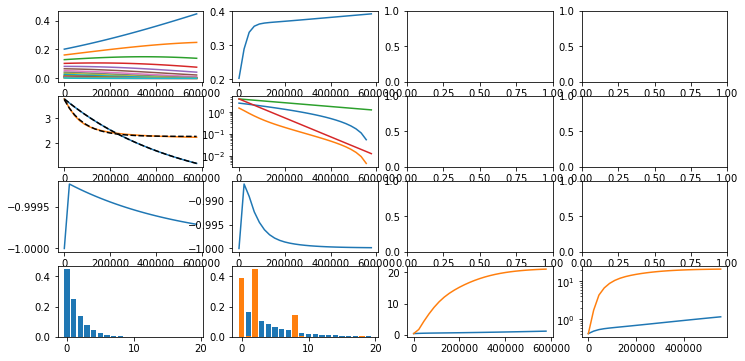

In [11]:
# Simulation of sideband cooling and trapped states
# Code to create n0=2 line of cooling rate

import numpy as np
import matplotlib.pyplot as plt
import time as time
from scipy.linalg import expm
import scipy.optimize

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

D=1
nu=1
eta=.02
Omega=.01
G=1000
ni=4
b=-np.log(ni/(ni+1))

print(f"Initial population {ni}")


nmax = 20
n0 = 2
tau = 2*np.pi/(Omega*eta*np.sqrt(n0))
tg = 2/G
dt = tau + tg
tsteps = 27

# operators
sz = np.array([[1,0j],[0j,-1]])
sx = np.array([[0j,1],[1,0j]])
sy = np.array([[0j,1j],[-1j,0j]])
Id = np.array([[1,0j],[-0j,1]])
Idn = np.eye(nmax)
sm = np.array([[0,0],[1,0j]])
a = np.diag(np.sqrt(np.arange(1,nmax)),1)
ad = np.transpose(a)
xop=a+ad
pop=a-ad
n = np.dot(ad,a)

#Liouvillian

#all order Hamiltonian
H = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)+Omega/2*(np.kron(expm(1j*eta*xop),sm)+np.kron(expm(-1j*eta*xop),sm.T))
#Lamb Dicke approximation
HLD = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(xop,sy)
#Jaynes Cummings approximation
HJC = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(ad,sm)+eta*Omega/2*np.kron(a,np.transpose(sm))
#decoupled Hamiltonian
H0 = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)

#spontaneous emission of the atom
D = np.kron(Idn,sm)
Dt = np.transpose(D)

ID = np.kron(Idn,Id)

#diffusion term of spontaneous emission
carrier=np.zeros(((nmax*2)**2,(nmax*2)**2),dtype=complex)
cosmax=100
cosal=np.arange(-cosmax,cosmax+1)/cosmax
W=3*(cosal**2+1)/4*1/2/cosmax
W=W/sum(W)
for i,c in enumerate(cosal):
    DD=np.kron(expm(1j*c*eta*xop),sm)
    carrier=carrier+W[i]*np.kron(DD,DD.conj()) #Spontaneous emission

#carrier=np.kron(D,D)

#trapped state lindbladians
#all-order coherent interaction
Lc = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H))
#reinitialization
Ld = -1j*np.kron(H0,ID) + 1j*np.kron(ID,np.transpose(H0)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling lindbladian
G=1*Omega
L = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling dynamical map
EL=expm(L*dt)
#trapped states dynamical map
ET=np.dot(expm(Ld*tg),expm(Lc*tau))

# tracer and rho0
rhoq=np.array([[0,0j],[0j,1]]) #State of qubit
rhon=expm(-b*nu*n)
rhon=rhon/np.trace(rhon)
rho0=np.kron(rhon,rhoq).reshape((nmax*2)**2,1)

tracer=np.kron(np.diag(Idn[:,0]),Id).reshape(1,(nmax*2)**2)
for i in np.arange(1,nmax):
    tracer=np.append(tracer,np.kron(np.diag(Idn[:,i]),Id).reshape(1,(nmax*2)**2),axis=0)

invtracer=np.kron(Idn,sz).reshape(1,(nmax*2)**2)

    
# State production
pn=np.zeros((nmax,tsteps),dtype=complex)
szt=np.zeros(tsteps,dtype=complex)
rho=rho0

pnT=np.zeros((nmax,tsteps),dtype=complex)
sztT=np.zeros(tsteps,dtype=complex)
QFI2=np.zeros((tsteps),dtype=complex)
QFI2T=np.zeros((tsteps),dtype=complex)
rhot=rho0

for i in np.arange(0,tsteps):
    pn[:,i:i+1]=np.dot(tracer,rho)
    szt[i]=np.dot(invtracer,rho)
    #rhosq=rho.reshape(nmax*2,nmax*2)
    #rhov=rhosq[::2,::2]+rhosq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhov)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rho=np.dot(EL,rho)
    
    pnT[:,i:i+1]=np.dot(tracer,rhot)
    sztT[i]=np.dot(invtracer,rhot)
    #rhotsq=rhot.reshape(nmax*2,nmax*2)
    #rhoTv=rhotsq[::2,::2]+rhotsq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhoTv)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2T[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rhot=np.dot(ET,rhot)

# Overlap as a function of displacement amplitude
almax=1000
dal=0.001
alpha=np.arange(0,almax)*dal
ov=np.zeros((nmax,almax),dtype=complex)
ovt=np.zeros((nmax,almax),dtype=complex)

#rhom=rho.reshape(nmax*2,nmax*2)
#rhotm=rhot.reshape(nmax*2,nmax*2)
#for i, al in enumerate(alpha):
#    d=expm(al*pop)
#    D=np.kron(d,Id)
#    Dt=D.conj().T
#    ov[:,i]=np.dot(tracer,np.dot(D,np.dot(rhom,Dt)).reshape((nmax*2)**2))
#    ovt[:,i]=np.dot(tracer,np.dot(D,np.dot(rhotm,Dt)).reshape((nmax*2)**2))

QFI=np.zeros((tsteps),dtype=complex)
QFIT=np.zeros((tsteps),dtype=complex)
dabs=np.abs(pop)**2
for j in np.arange(0,tsteps):
    v=np.kron(pn[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFI[j]=2*np.sum((v-h)**2/(v+h)*dabs)
    v=np.kron(pnT[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFIT[j]=2*np.sum((v-h)**2/(v+h)*dabs)



# Fisher information (it involves a numerical derivative and needs a very small dal)
#FI=np.diff(ov)**2/(ov[:,0:-1]-ov[:,0:-1]**2)/dal**2
#FIT=np.diff(ovt)**2/(ovt[:,0:-1]-ovt[:,0:-1]**2)/dal**2    


#Phonon number
nav=np.dot(np.diag(n),np.real(pn))
nTav=np.dot(np.diag(n),np.real(pnT))
ts= np.arange(0,tsteps)*dt
print(f"Final population sideband cooling: {nav[-1]}")

#Fitting
# perform the fit for population
p0 = (ni, eta**2*Omega/2, 0.01) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, ts, nav, p0)
m, t, b = params

p0T = (ni, eta*Omega/2*0.1, 4) # start with values near those we expect
paramsT, cvT = scipy.optimize.curve_fit(monoExp, ts, nTav, p0T)
mT, tT, bT = paramsT

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}; expected rate {eta**2*Omega/2}")
print(f"Y = {mT} * e^(-{tT} * x) + {bT}; expected rate {eta*Omega/2*0.1}")

# determine quality of the fit
squaredDiffs = np.square(nav - monoExp(ts, m, t, b))
squaredDiffsFromMean = np.square(nav - np.mean(nav))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

squaredDiffsT = np.square(nTav - monoExp(ts, mT, tT, bT))
squaredDiffsFromMeanT = np.square(nTav - np.mean(nTav))
rSquaredT = 1 - np.sum(squaredDiffsT) / np.sum(squaredDiffsFromMeanT)
print(f"R² = {rSquaredT}")

# perform the fit for QFI
#QFI0 = (0, eta**2*Omega/2, 0.01) # start with values near those we expect
#paramsQ, cvQ = scipy.optimize.curve_fit(monoExp, ts, QFI, QFI0)
#mQ, tQ, bQ = paramsQ

#QFI0T = (0, eta*Omega/2*0.1, 4) # start with values near those we expect
#paramsQT, cvQT = scipy.optimize.curve_fit(monoExp, ts, QFIT, QFI0T)
#mQT, tQT, bQT = paramsQT

# inspect the parameters
#print(f"Y = {mQ} * e^(-{t} * x) + {bQ}; expected rate {eta**2*Omega/2}")
#print(f"Y = {mQT} * e^(-{t} * x) + {bQT}; expected rate {eta*Omega/2*0.13}")

# determine quality of the fit
#squaredDiffsQ = np.square(QFI - monoExp(ts, mQ, tQ, bQ))
#squaredDiffsFromMeanQ = np.square(QFI - np.mean(QFI))
#rSquaredQ = 1 - np.sum(squaredDiffsQ) / np.sum(squaredDiffsFromMeanQ)
#print(f"R² = {rSquaredQ}")

#squaredDiffsQT = np.square(QFIT - monoExp(ts, mQT, tQT, bQT))
#squaredDiffsFromMeanQT = np.square(QFIT - np.mean(QFIT))
#rSquaredQT = 1 - np.sum(squaredDiffsQT) / np.sum(squaredDiffsFromMeanQT)
#print(f"R² = {rSquaredQT}")


# Plotting    
fig, axes = plt.subplots(4, 4, figsize=(12,6))

for i in np.arange(0,nmax):
    axes[0,0].plot(np.arange(0,tsteps)*dt, np.real(pn[i,:]))

    #axes[1,2].plot(alpha, np.real(ov[i,:]))
    #axes[2,2].plot(alpha, np.real(ovt[i,:]))

    #axes[1,3].plot(alpha[0:-1], np.real(FI[i,:]))
    #axes[2,3].plot(alpha[0:-1], np.real(FIT[i,:]))


# This shows how much population is lost from the first trap as a function of time
axes[0,1].plot(np.arange(0,tsteps)*dt, np.real(0*pnT[1,:]+pnT[0,:]))


# overlap and FI of final state    
#axes[0,2].plot(alpha, np.real(ov[0,:]))
#axes[0,2].plot(alpha, np.real(ovt[1,:]))

#axes[0,3].plot(alpha[0:-1], np.real(FI[0,:]))
#axes[0,3].plot(alpha[0:-1], np.real(FIT[2,:]))


# Population decay as a function of time
axes[1,0].plot(ts, nav)
axes[1,0].plot(ts, nTav)
axes[1,0].plot(ts, monoExp(ts, m, t, b), 'k--', label="fitted")
axes[1,0].plot(ts, monoExp(ts, mT, tT, bT), 'k--', label="T fitted")

axes[1,1].set_yscale('log')

axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pn[:,:-1]))-np.dot(np.diag(n),np.real(pn[:,-1])))
axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pnT[:,:-1]))-np.dot(np.diag(n),np.real(pnT[:,-1])))
axes[1,1].plot(ts, monoExp(ts, ni, eta**2*Omega/2, 1)-1)
axes[1,1].plot(ts, monoExp(ts, ni, eta*Omega/2*0.1, 1)-1)

# Useful to check whether the carrier excitation is relevant. The closer to -1 the less carrier heating.
axes[2,0].plot(np.arange(0,tsteps)*dt, np.real(szt))
axes[2,1].plot(ts, np.real(sztT))

# (Initial) Final state
axes[3,0].bar(np.diag(n), np.real(pn[:,-1]))

axes[3,1].bar(np.diag(n), np.real(pnT[:,0]))
axes[3,1].bar(np.diag(n), np.real(pnT[:,-1]))

#PT=np.append(np.transpose([np.diag(n)]), np.transpose([np.real(pnT[:,-1])]),axis=1)
#print(PT)
#np.savetxt('simomega02.dat',PT)

#Time evolution of QFI
axes[3,2].plot(ts,np.real(QFI))
axes[3,2].plot(ts,np.real(QFIT))
#axes[3,2].plot(ts, monoExp(ts, mQ, tQ, bQ), '--', label="fitted")
#axes[3,2].plot(ts, monoExp(ts, mQT, tQT, bQT), '--', label="fitted")

axes[3,3].set_yscale('log')
tmax=tsteps
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFI[0:tmax-1]-0*QFI[tmax-1]))
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFIT[0:tmax-1]-0*np.max(QFIT)))



Ratetxt=np.append(np.transpose([np.arange(0,tmax-1)*dt]), np.transpose([np.real(nTav[0:tmax-1])]),axis=1)
np.savetxt('Nn02.dat',Ratetxt)



Initial population 4
Final population sideband cooling: 1.142095471794302
Y = 3.773302280889356 * e^(-1.9882395358562764e-06 * x) + -0.005908447785662443; expected rate 2.0000000000000003e-06
Y = 1.6794955288724898 * e^(-1.2688327605051678e-05 * x) + 2.0511472746866812; expected rate 1e-05
R² = 0.9999999647709688
R² = 0.9976936660604394


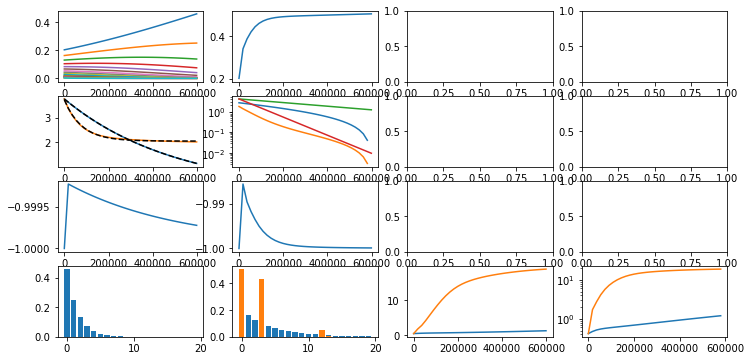

In [14]:
# Simulation of sideband cooling and trapped states
# Code to create n0=3 line of cooling rate

import numpy as np
import matplotlib.pyplot as plt
import time as time
from scipy.linalg import expm
import scipy.optimize

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

D=1
nu=1
eta=.02
Omega=.01
G=1000
ni=4
b=-np.log(ni/(ni+1))

print(f"Initial population {ni}")


nmax = 20
n0 = 3
tau = 2*np.pi/(Omega*eta*np.sqrt(n0))
tg = 2/G
dt = tau + tg
tsteps = 34

# operators
sz = np.array([[1,0j],[0j,-1]])
sx = np.array([[0j,1],[1,0j]])
sy = np.array([[0j,1j],[-1j,0j]])
Id = np.array([[1,0j],[-0j,1]])
Idn = np.eye(nmax)
sm = np.array([[0,0],[1,0j]])
a = np.diag(np.sqrt(np.arange(1,nmax)),1)
ad = np.transpose(a)
xop=a+ad
pop=a-ad
n = np.dot(ad,a)

#Liouvillian

#all order Hamiltonian
H = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)+Omega/2*(np.kron(expm(1j*eta*xop),sm)+np.kron(expm(-1j*eta*xop),sm.T))
#Lamb Dicke approximation
HLD = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(xop,sy)
#Jaynes Cummings approximation
HJC = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(ad,sm)+eta*Omega/2*np.kron(a,np.transpose(sm))
#decoupled Hamiltonian
H0 = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)

#spontaneous emission of the atom
D = np.kron(Idn,sm)
Dt = np.transpose(D)

ID = np.kron(Idn,Id)

#diffusion term of spontaneous emission
carrier=np.zeros(((nmax*2)**2,(nmax*2)**2),dtype=complex)
cosmax=100
cosal=np.arange(-cosmax,cosmax+1)/cosmax
W=3*(cosal**2+1)/4*1/2/cosmax
W=W/sum(W)
for i,c in enumerate(cosal):
    DD=np.kron(expm(1j*c*eta*xop),sm)
    carrier=carrier+W[i]*np.kron(DD,DD.conj()) #Spontaneous emission

#carrier=np.kron(D,D)

#trapped state lindbladians
#all-order coherent interaction
Lc = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H))
#reinitialization
Ld = -1j*np.kron(H0,ID) + 1j*np.kron(ID,np.transpose(H0)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling lindbladian
G=1*Omega
L = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling dynamical map
EL=expm(L*dt)
#trapped states dynamical map
ET=np.dot(expm(Ld*tg),expm(Lc*tau))

# tracer and rho0
rhoq=np.array([[0,0j],[0j,1]]) #State of qubit
rhon=expm(-b*nu*n)
rhon=rhon/np.trace(rhon)
rho0=np.kron(rhon,rhoq).reshape((nmax*2)**2,1)

tracer=np.kron(np.diag(Idn[:,0]),Id).reshape(1,(nmax*2)**2)
for i in np.arange(1,nmax):
    tracer=np.append(tracer,np.kron(np.diag(Idn[:,i]),Id).reshape(1,(nmax*2)**2),axis=0)

invtracer=np.kron(Idn,sz).reshape(1,(nmax*2)**2)

    
# State production
pn=np.zeros((nmax,tsteps),dtype=complex)
szt=np.zeros(tsteps,dtype=complex)
rho=rho0

pnT=np.zeros((nmax,tsteps),dtype=complex)
sztT=np.zeros(tsteps,dtype=complex)
QFI2=np.zeros((tsteps),dtype=complex)
QFI2T=np.zeros((tsteps),dtype=complex)
rhot=rho0

for i in np.arange(0,tsteps):
    pn[:,i:i+1]=np.dot(tracer,rho)
    szt[i]=np.dot(invtracer,rho)
    #rhosq=rho.reshape(nmax*2,nmax*2)
    #rhov=rhosq[::2,::2]+rhosq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhov)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rho=np.dot(EL,rho)
    
    pnT[:,i:i+1]=np.dot(tracer,rhot)
    sztT[i]=np.dot(invtracer,rhot)
    #rhotsq=rhot.reshape(nmax*2,nmax*2)
    #rhoTv=rhotsq[::2,::2]+rhotsq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhoTv)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2T[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rhot=np.dot(ET,rhot)

# Overlap as a function of displacement amplitude
almax=1000
dal=0.001
alpha=np.arange(0,almax)*dal
ov=np.zeros((nmax,almax),dtype=complex)
ovt=np.zeros((nmax,almax),dtype=complex)

#rhom=rho.reshape(nmax*2,nmax*2)
#rhotm=rhot.reshape(nmax*2,nmax*2)
#for i, al in enumerate(alpha):
#    d=expm(al*pop)
#    D=np.kron(d,Id)
#    Dt=D.conj().T
#    ov[:,i]=np.dot(tracer,np.dot(D,np.dot(rhom,Dt)).reshape((nmax*2)**2))
#    ovt[:,i]=np.dot(tracer,np.dot(D,np.dot(rhotm,Dt)).reshape((nmax*2)**2))

QFI=np.zeros((tsteps),dtype=complex)
QFIT=np.zeros((tsteps),dtype=complex)
dabs=np.abs(pop)**2
for j in np.arange(0,tsteps):
    v=np.kron(pn[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFI[j]=2*np.sum((v-h)**2/(v+h)*dabs)
    v=np.kron(pnT[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFIT[j]=2*np.sum((v-h)**2/(v+h)*dabs)



# Fisher information (it involves a numerical derivative and needs a very small dal)
#FI=np.diff(ov)**2/(ov[:,0:-1]-ov[:,0:-1]**2)/dal**2
#FIT=np.diff(ovt)**2/(ovt[:,0:-1]-ovt[:,0:-1]**2)/dal**2    


#Phonon number
nav=np.dot(np.diag(n),np.real(pn))
nTav=np.dot(np.diag(n),np.real(pnT))
ts= np.arange(0,tsteps)*dt
print(f"Final population sideband cooling: {nav[-1]}")

#Fitting
# perform the fit for population
p0 = (ni, eta**2*Omega/2, 0.01) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, ts, nav, p0)
m, t, b = params

p0T = (ni, eta*Omega/2*0.1, 4) # start with values near those we expect
paramsT, cvT = scipy.optimize.curve_fit(monoExp, ts, nTav, p0T)
mT, tT, bT = paramsT

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}; expected rate {eta**2*Omega/2}")
print(f"Y = {mT} * e^(-{tT} * x) + {bT}; expected rate {eta*Omega/2*0.1}")

# determine quality of the fit
squaredDiffs = np.square(nav - monoExp(ts, m, t, b))
squaredDiffsFromMean = np.square(nav - np.mean(nav))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

squaredDiffsT = np.square(nTav - monoExp(ts, mT, tT, bT))
squaredDiffsFromMeanT = np.square(nTav - np.mean(nTav))
rSquaredT = 1 - np.sum(squaredDiffsT) / np.sum(squaredDiffsFromMeanT)
print(f"R² = {rSquaredT}")

# perform the fit for QFI
#QFI0 = (0, eta**2*Omega/2, 0.01) # start with values near those we expect
#paramsQ, cvQ = scipy.optimize.curve_fit(monoExp, ts, QFI, QFI0)
#mQ, tQ, bQ = paramsQ

#QFI0T = (0, eta*Omega/2*0.1, 4) # start with values near those we expect
#paramsQT, cvQT = scipy.optimize.curve_fit(monoExp, ts, QFIT, QFI0T)
#mQT, tQT, bQT = paramsQT

# inspect the parameters
#print(f"Y = {mQ} * e^(-{t} * x) + {bQ}; expected rate {eta**2*Omega/2}")
#print(f"Y = {mQT} * e^(-{t} * x) + {bQT}; expected rate {eta*Omega/2*0.13}")

# determine quality of the fit
#squaredDiffsQ = np.square(QFI - monoExp(ts, mQ, tQ, bQ))
#squaredDiffsFromMeanQ = np.square(QFI - np.mean(QFI))
#rSquaredQ = 1 - np.sum(squaredDiffsQ) / np.sum(squaredDiffsFromMeanQ)
#print(f"R² = {rSquaredQ}")

#squaredDiffsQT = np.square(QFIT - monoExp(ts, mQT, tQT, bQT))
#squaredDiffsFromMeanQT = np.square(QFIT - np.mean(QFIT))
#rSquaredQT = 1 - np.sum(squaredDiffsQT) / np.sum(squaredDiffsFromMeanQT)
#print(f"R² = {rSquaredQT}")


# Plotting    
fig, axes = plt.subplots(4, 4, figsize=(12,6))

for i in np.arange(0,nmax):
    axes[0,0].plot(np.arange(0,tsteps)*dt, np.real(pn[i,:]))

    #axes[1,2].plot(alpha, np.real(ov[i,:]))
    #axes[2,2].plot(alpha, np.real(ovt[i,:]))

    #axes[1,3].plot(alpha[0:-1], np.real(FI[i,:]))
    #axes[2,3].plot(alpha[0:-1], np.real(FIT[i,:]))


# This shows how much population is lost from the first trap as a function of time
axes[0,1].plot(np.arange(0,tsteps)*dt, np.real(0*pnT[1,:]+pnT[0,:]))


# overlap and FI of final state    
#axes[0,2].plot(alpha, np.real(ov[0,:]))
#axes[0,2].plot(alpha, np.real(ovt[1,:]))

#axes[0,3].plot(alpha[0:-1], np.real(FI[0,:]))
#axes[0,3].plot(alpha[0:-1], np.real(FIT[2,:]))


# Population decay as a function of time
axes[1,0].plot(ts, nav)
axes[1,0].plot(ts, nTav)
axes[1,0].plot(ts, monoExp(ts, m, t, b), 'k--', label="fitted")
axes[1,0].plot(ts, monoExp(ts, mT, tT, bT), 'k--', label="T fitted")

axes[1,1].set_yscale('log')

axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pn[:,:-1]))-np.dot(np.diag(n),np.real(pn[:,-1])))
axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pnT[:,:-1]))-np.dot(np.diag(n),np.real(pnT[:,-1])))
axes[1,1].plot(ts, monoExp(ts, ni, eta**2*Omega/2, 1)-1)
axes[1,1].plot(ts, monoExp(ts, ni, eta*Omega/2*0.1, 1)-1)

# Useful to check whether the carrier excitation is relevant. The closer to -1 the less carrier heating.
axes[2,0].plot(np.arange(0,tsteps)*dt, np.real(szt))
axes[2,1].plot(ts, np.real(sztT))

# (Initial) Final state
axes[3,0].bar(np.diag(n), np.real(pn[:,-1]))

axes[3,1].bar(np.diag(n), np.real(pnT[:,0]))
axes[3,1].bar(np.diag(n), np.real(pnT[:,-1]))

#PT=np.append(np.transpose([np.diag(n)]), np.transpose([np.real(pnT[:,-1])]),axis=1)
#print(PT)
#np.savetxt('simomega02.dat',PT)

#Time evolution of QFI
axes[3,2].plot(ts,np.real(QFI))
axes[3,2].plot(ts,np.real(QFIT))
#axes[3,2].plot(ts, monoExp(ts, mQ, tQ, bQ), '--', label="fitted")
#axes[3,2].plot(ts, monoExp(ts, mQT, tQT, bQT), '--', label="fitted")

axes[3,3].set_yscale('log')
tmax=tsteps
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFI[0:tmax-1]-0*QFI[tmax-1]))
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFIT[0:tmax-1]-0*np.max(QFIT)))



Ratetxt=np.append(np.transpose([np.arange(0,tmax-1)*dt]), np.transpose([np.real(nTav[0:tmax-1])]),axis=1)
np.savetxt('Nn03.dat',Ratetxt)

Initial population 4
Final population sideband cooling: 1.1458662556958006
Y = 3.7732591882726734 * e^(-1.9883200286238117e-06 * x) + -0.005838735593005049; expected rate 2.0000000000000003e-06
Y = 1.8589066013455373 * e^(-1.2429382168095717e-05 * x) + 1.8410171964213893; expected rate 1e-05
R² = 0.9999999674763
R² = 0.9974959291569473


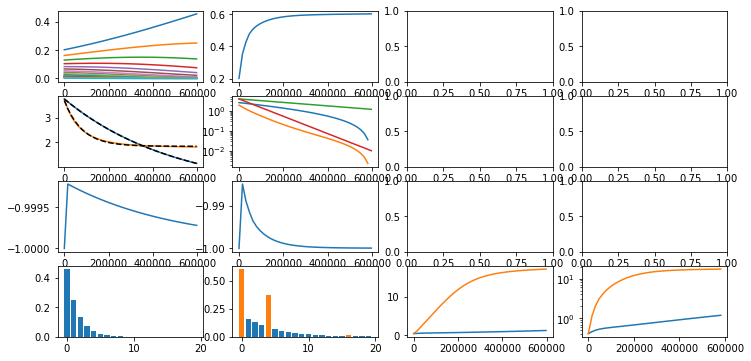

In [20]:
# Simulation of sideband cooling and trapped states
# Code to create n0=4 line of cooling rate

import numpy as np
import matplotlib.pyplot as plt
import time as time
from scipy.linalg import expm
import scipy.optimize

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

D=1
nu=1
eta=.02
Omega=.01
G=1000
ni=4
b=-np.log(ni/(ni+1))

print(f"Initial population {ni}")


nmax = 20
n0 = 4
tau = 2*np.pi/(Omega*eta*np.sqrt(n0))
tg = 2/G
dt = tau + tg
tsteps = 39

# operators
sz = np.array([[1,0j],[0j,-1]])
sx = np.array([[0j,1],[1,0j]])
sy = np.array([[0j,1j],[-1j,0j]])
Id = np.array([[1,0j],[-0j,1]])
Idn = np.eye(nmax)
sm = np.array([[0,0],[1,0j]])
a = np.diag(np.sqrt(np.arange(1,nmax)),1)
ad = np.transpose(a)
xop=a+ad
pop=a-ad
n = np.dot(ad,a)

#Liouvillian

#all order Hamiltonian
H = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)+Omega/2*(np.kron(expm(1j*eta*xop),sm)+np.kron(expm(-1j*eta*xop),sm.T))
#Lamb Dicke approximation
HLD = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(xop,sy)
#Jaynes Cummings approximation
HJC = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(ad,sm)+eta*Omega/2*np.kron(a,np.transpose(sm))
#decoupled Hamiltonian
H0 = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)

#spontaneous emission of the atom
D = np.kron(Idn,sm)
Dt = np.transpose(D)

ID = np.kron(Idn,Id)

#diffusion term of spontaneous emission
carrier=np.zeros(((nmax*2)**2,(nmax*2)**2),dtype=complex)
cosmax=100
cosal=np.arange(-cosmax,cosmax+1)/cosmax
W=3*(cosal**2+1)/4*1/2/cosmax
W=W/sum(W)
for i,c in enumerate(cosal):
    DD=np.kron(expm(1j*c*eta*xop),sm)
    carrier=carrier+W[i]*np.kron(DD,DD.conj()) #Spontaneous emission

#carrier=np.kron(D,D)

#trapped state lindbladians
#all-order coherent interaction
Lc = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H))
#reinitialization
Ld = -1j*np.kron(H0,ID) + 1j*np.kron(ID,np.transpose(H0)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling lindbladian
G=1*Omega
L = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling dynamical map
EL=expm(L*dt)
#trapped states dynamical map
ET=np.dot(expm(Ld*tg),expm(Lc*tau))

# tracer and rho0
rhoq=np.array([[0,0j],[0j,1]]) #State of qubit
rhon=expm(-b*nu*n)
rhon=rhon/np.trace(rhon)
rho0=np.kron(rhon,rhoq).reshape((nmax*2)**2,1)

tracer=np.kron(np.diag(Idn[:,0]),Id).reshape(1,(nmax*2)**2)
for i in np.arange(1,nmax):
    tracer=np.append(tracer,np.kron(np.diag(Idn[:,i]),Id).reshape(1,(nmax*2)**2),axis=0)

invtracer=np.kron(Idn,sz).reshape(1,(nmax*2)**2)

    
# State production
pn=np.zeros((nmax,tsteps),dtype=complex)
szt=np.zeros(tsteps,dtype=complex)
rho=rho0

pnT=np.zeros((nmax,tsteps),dtype=complex)
sztT=np.zeros(tsteps,dtype=complex)
QFI2=np.zeros((tsteps),dtype=complex)
QFI2T=np.zeros((tsteps),dtype=complex)
rhot=rho0

for i in np.arange(0,tsteps):
    pn[:,i:i+1]=np.dot(tracer,rho)
    szt[i]=np.dot(invtracer,rho)
    #rhosq=rho.reshape(nmax*2,nmax*2)
    #rhov=rhosq[::2,::2]+rhosq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhov)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rho=np.dot(EL,rho)
    
    pnT[:,i:i+1]=np.dot(tracer,rhot)
    sztT[i]=np.dot(invtracer,rhot)
    #rhotsq=rhot.reshape(nmax*2,nmax*2)
    #rhoTv=rhotsq[::2,::2]+rhotsq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhoTv)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2T[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rhot=np.dot(ET,rhot)

# Overlap as a function of displacement amplitude
almax=1000
dal=0.001
alpha=np.arange(0,almax)*dal
ov=np.zeros((nmax,almax),dtype=complex)
ovt=np.zeros((nmax,almax),dtype=complex)

#rhom=rho.reshape(nmax*2,nmax*2)
#rhotm=rhot.reshape(nmax*2,nmax*2)
#for i, al in enumerate(alpha):
#    d=expm(al*pop)
#    D=np.kron(d,Id)
#    Dt=D.conj().T
#    ov[:,i]=np.dot(tracer,np.dot(D,np.dot(rhom,Dt)).reshape((nmax*2)**2))
#    ovt[:,i]=np.dot(tracer,np.dot(D,np.dot(rhotm,Dt)).reshape((nmax*2)**2))

QFI=np.zeros((tsteps),dtype=complex)
QFIT=np.zeros((tsteps),dtype=complex)
dabs=np.abs(pop)**2
for j in np.arange(0,tsteps):
    v=np.kron(pn[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFI[j]=2*np.sum((v-h)**2/(v+h)*dabs)
    v=np.kron(pnT[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFIT[j]=2*np.sum((v-h)**2/(v+h)*dabs)



# Fisher information (it involves a numerical derivative and needs a very small dal)
#FI=np.diff(ov)**2/(ov[:,0:-1]-ov[:,0:-1]**2)/dal**2
#FIT=np.diff(ovt)**2/(ovt[:,0:-1]-ovt[:,0:-1]**2)/dal**2    


#Phonon number
nav=np.dot(np.diag(n),np.real(pn))
nTav=np.dot(np.diag(n),np.real(pnT))
ts= np.arange(0,tsteps)*dt
print(f"Final population sideband cooling: {nav[-1]}")

#Fitting
# perform the fit for population
p0 = (ni, eta**2*Omega/2, 0.01) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, ts, nav, p0)
m, t, b = params

p0T = (ni, eta*Omega/2*0.1, 4) # start with values near those we expect
paramsT, cvT = scipy.optimize.curve_fit(monoExp, ts, nTav, p0T)
mT, tT, bT = paramsT

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}; expected rate {eta**2*Omega/2}")
print(f"Y = {mT} * e^(-{tT} * x) + {bT}; expected rate {eta*Omega/2*0.1}")

# determine quality of the fit
squaredDiffs = np.square(nav - monoExp(ts, m, t, b))
squaredDiffsFromMean = np.square(nav - np.mean(nav))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

squaredDiffsT = np.square(nTav - monoExp(ts, mT, tT, bT))
squaredDiffsFromMeanT = np.square(nTav - np.mean(nTav))
rSquaredT = 1 - np.sum(squaredDiffsT) / np.sum(squaredDiffsFromMeanT)
print(f"R² = {rSquaredT}")

# perform the fit for QFI
#QFI0 = (0, eta**2*Omega/2, 0.01) # start with values near those we expect
#paramsQ, cvQ = scipy.optimize.curve_fit(monoExp, ts, QFI, QFI0)
#mQ, tQ, bQ = paramsQ

#QFI0T = (0, eta*Omega/2*0.1, 4) # start with values near those we expect
#paramsQT, cvQT = scipy.optimize.curve_fit(monoExp, ts, QFIT, QFI0T)
#mQT, tQT, bQT = paramsQT

# inspect the parameters
#print(f"Y = {mQ} * e^(-{t} * x) + {bQ}; expected rate {eta**2*Omega/2}")
#print(f"Y = {mQT} * e^(-{t} * x) + {bQT}; expected rate {eta*Omega/2*0.13}")

# determine quality of the fit
#squaredDiffsQ = np.square(QFI - monoExp(ts, mQ, tQ, bQ))
#squaredDiffsFromMeanQ = np.square(QFI - np.mean(QFI))
#rSquaredQ = 1 - np.sum(squaredDiffsQ) / np.sum(squaredDiffsFromMeanQ)
#print(f"R² = {rSquaredQ}")

#squaredDiffsQT = np.square(QFIT - monoExp(ts, mQT, tQT, bQT))
#squaredDiffsFromMeanQT = np.square(QFIT - np.mean(QFIT))
#rSquaredQT = 1 - np.sum(squaredDiffsQT) / np.sum(squaredDiffsFromMeanQT)
#print(f"R² = {rSquaredQT}")


# Plotting    
fig, axes = plt.subplots(4, 4, figsize=(12,6))

for i in np.arange(0,nmax):
    axes[0,0].plot(np.arange(0,tsteps)*dt, np.real(pn[i,:]))

    #axes[1,2].plot(alpha, np.real(ov[i,:]))
    #axes[2,2].plot(alpha, np.real(ovt[i,:]))

    #axes[1,3].plot(alpha[0:-1], np.real(FI[i,:]))
    #axes[2,3].plot(alpha[0:-1], np.real(FIT[i,:]))


# This shows how much population is lost from the first trap as a function of time
axes[0,1].plot(np.arange(0,tsteps)*dt, np.real(0*pnT[1,:]+pnT[0,:]))


# overlap and FI of final state    
#axes[0,2].plot(alpha, np.real(ov[0,:]))
#axes[0,2].plot(alpha, np.real(ovt[1,:]))

#axes[0,3].plot(alpha[0:-1], np.real(FI[0,:]))
#axes[0,3].plot(alpha[0:-1], np.real(FIT[2,:]))


# Population decay as a function of time
axes[1,0].plot(ts, nav)
axes[1,0].plot(ts, nTav)
axes[1,0].plot(ts, monoExp(ts, m, t, b), 'k--', label="fitted")
axes[1,0].plot(ts, monoExp(ts, mT, tT, bT), 'k--', label="T fitted")

axes[1,1].set_yscale('log')

axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pn[:,:-1]))-np.dot(np.diag(n),np.real(pn[:,-1])))
axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pnT[:,:-1]))-np.dot(np.diag(n),np.real(pnT[:,-1])))
axes[1,1].plot(ts, monoExp(ts, ni, eta**2*Omega/2, 1)-1)
axes[1,1].plot(ts, monoExp(ts, ni, eta*Omega/2*0.1, 1)-1)

# Useful to check whether the carrier excitation is relevant. The closer to -1 the less carrier heating.
axes[2,0].plot(np.arange(0,tsteps)*dt, np.real(szt))
axes[2,1].plot(ts, np.real(sztT))

# (Initial) Final state
axes[3,0].bar(np.diag(n), np.real(pn[:,-1]))

axes[3,1].bar(np.diag(n), np.real(pnT[:,0]))
axes[3,1].bar(np.diag(n), np.real(pnT[:,-1]))

#PT=np.append(np.transpose([np.diag(n)]), np.transpose([np.real(pnT[:,-1])]),axis=1)
#print(PT)
#np.savetxt('simomega02.dat',PT)

#Time evolution of QFI
axes[3,2].plot(ts,np.real(QFI))
axes[3,2].plot(ts,np.real(QFIT))
#axes[3,2].plot(ts, monoExp(ts, mQ, tQ, bQ), '--', label="fitted")
#axes[3,2].plot(ts, monoExp(ts, mQT, tQT, bQT), '--', label="fitted")

axes[3,3].set_yscale('log')
tmax=tsteps
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFI[0:tmax-1]-0*QFI[tmax-1]))
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFIT[0:tmax-1]-0*np.max(QFIT)))



Ratetxt=np.append(np.transpose([np.arange(0,tmax-1)*dt]), np.transpose([np.real(nTav[0:tmax-1])]),axis=1)
np.savetxt('Nn04.dat',Ratetxt)

Initial population 4
Final population sideband cooling: 1.1615689988018847
Y = 3.773289410464879 * e^(-1.988324809294638e-06 * x) + -0.005854178641622714; expected rate 2.0000000000000003e-06
Y = 2.0141333116869995 * e^(-1.2400955108445332e-05 * x) + 1.645806691570531; expected rate 1e-05
R² = 0.9999999694137539
R² = 0.9950824037529924


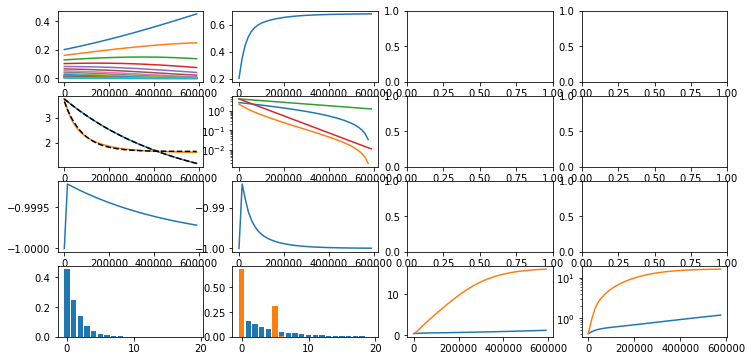

In [15]:
# Simulation of sideband cooling and trapped states
# Code to create n0=5 line of cooling rate

import numpy as np
import matplotlib.pyplot as plt
import time as time
from scipy.linalg import expm
import scipy.optimize

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

D=1
nu=1
eta=.02
Omega=.01
G=1000
ni=4
b=-np.log(ni/(ni+1))

print(f"Initial population {ni}")


nmax = 20
n0 = 5
tau = 2*np.pi/(Omega*eta*np.sqrt(n0))
tg = 2/G
dt = tau + tg
tsteps = 43

# operators
sz = np.array([[1,0j],[0j,-1]])
sx = np.array([[0j,1],[1,0j]])
sy = np.array([[0j,1j],[-1j,0j]])
Id = np.array([[1,0j],[-0j,1]])
Idn = np.eye(nmax)
sm = np.array([[0,0],[1,0j]])
a = np.diag(np.sqrt(np.arange(1,nmax)),1)
ad = np.transpose(a)
xop=a+ad
pop=a-ad
n = np.dot(ad,a)

#Liouvillian

#all order Hamiltonian
H = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)+Omega/2*(np.kron(expm(1j*eta*xop),sm)+np.kron(expm(-1j*eta*xop),sm.T))
#Lamb Dicke approximation
HLD = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(xop,sy)
#Jaynes Cummings approximation
HJC = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2+Omega/2*sx)+eta*Omega/2*np.kron(ad,sm)+eta*Omega/2*np.kron(a,np.transpose(sm))
#decoupled Hamiltonian
H0 = np.kron(nu*n,Id)+np.kron(Idn,D*sz/2)

#spontaneous emission of the atom
D = np.kron(Idn,sm)
Dt = np.transpose(D)

ID = np.kron(Idn,Id)

#diffusion term of spontaneous emission
carrier=np.zeros(((nmax*2)**2,(nmax*2)**2),dtype=complex)
cosmax=100
cosal=np.arange(-cosmax,cosmax+1)/cosmax
W=3*(cosal**2+1)/4*1/2/cosmax
W=W/sum(W)
for i,c in enumerate(cosal):
    DD=np.kron(expm(1j*c*eta*xop),sm)
    carrier=carrier+W[i]*np.kron(DD,DD.conj()) #Spontaneous emission

#carrier=np.kron(D,D)

#trapped state lindbladians
#all-order coherent interaction
Lc = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H))
#reinitialization
Ld = -1j*np.kron(H0,ID) + 1j*np.kron(ID,np.transpose(H0)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling lindbladian
G=1*Omega
L = -1j*np.kron(H,ID) + 1j*np.kron(ID,np.transpose(H)) + 2*G*carrier - G*np.kron(np.dot(Dt,D),ID) - G*np.kron(ID,np.dot(Dt,D))

#sideband cooling dynamical map
EL=expm(L*dt)
#trapped states dynamical map
ET=np.dot(expm(Ld*tg),expm(Lc*tau))

# tracer and rho0
rhoq=np.array([[0,0j],[0j,1]]) #State of qubit
rhon=expm(-b*nu*n)
rhon=rhon/np.trace(rhon)
rho0=np.kron(rhon,rhoq).reshape((nmax*2)**2,1)

tracer=np.kron(np.diag(Idn[:,0]),Id).reshape(1,(nmax*2)**2)
for i in np.arange(1,nmax):
    tracer=np.append(tracer,np.kron(np.diag(Idn[:,i]),Id).reshape(1,(nmax*2)**2),axis=0)

invtracer=np.kron(Idn,sz).reshape(1,(nmax*2)**2)

    
# State production
pn=np.zeros((nmax,tsteps),dtype=complex)
szt=np.zeros(tsteps,dtype=complex)
rho=rho0

pnT=np.zeros((nmax,tsteps),dtype=complex)
sztT=np.zeros(tsteps,dtype=complex)
QFI2=np.zeros((tsteps),dtype=complex)
QFI2T=np.zeros((tsteps),dtype=complex)
rhot=rho0

for i in np.arange(0,tsteps):
    pn[:,i:i+1]=np.dot(tracer,rho)
    szt[i]=np.dot(invtracer,rho)
    #rhosq=rho.reshape(nmax*2,nmax*2)
    #rhov=rhosq[::2,::2]+rhosq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhov)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rho=np.dot(EL,rho)
    
    pnT[:,i:i+1]=np.dot(tracer,rhot)
    sztT[i]=np.dot(invtracer,rhot)
    #rhotsq=rhot.reshape(nmax*2,nmax*2)
    #rhoTv=rhotsq[::2,::2]+rhotsq[1::2,1::2] #vibrational density matrix (partial trace)
    #w,v=np.linalg.eig(rhoTv)
    #opsq=np.abs(np.dot(v.conj().T,np.dot(pop,v)))**2
    #wM=np.kron(np.ones((nmax,1)),w)
    #h=wM.T
    #QFI2T[i]=2*np.sum((wM-h)**2/(wM+h)*opsq)
    rhot=np.dot(ET,rhot)

# Overlap as a function of displacement amplitude
almax=1000
dal=0.001
alpha=np.arange(0,almax)*dal
ov=np.zeros((nmax,almax),dtype=complex)
ovt=np.zeros((nmax,almax),dtype=complex)

#rhom=rho.reshape(nmax*2,nmax*2)
#rhotm=rhot.reshape(nmax*2,nmax*2)
#for i, al in enumerate(alpha):
#    d=expm(al*pop)
#    D=np.kron(d,Id)
#    Dt=D.conj().T
#    ov[:,i]=np.dot(tracer,np.dot(D,np.dot(rhom,Dt)).reshape((nmax*2)**2))
#    ovt[:,i]=np.dot(tracer,np.dot(D,np.dot(rhotm,Dt)).reshape((nmax*2)**2))

QFI=np.zeros((tsteps),dtype=complex)
QFIT=np.zeros((tsteps),dtype=complex)
dabs=np.abs(pop)**2
for j in np.arange(0,tsteps):
    v=np.kron(pn[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFI[j]=2*np.sum((v-h)**2/(v+h)*dabs)
    v=np.kron(pnT[:,j:j+1],np.ones((1,nmax),dtype=complex))
    h=v.T
    QFIT[j]=2*np.sum((v-h)**2/(v+h)*dabs)



# Fisher information (it involves a numerical derivative and needs a very small dal)
#FI=np.diff(ov)**2/(ov[:,0:-1]-ov[:,0:-1]**2)/dal**2
#FIT=np.diff(ovt)**2/(ovt[:,0:-1]-ovt[:,0:-1]**2)/dal**2    


#Phonon number
nav=np.dot(np.diag(n),np.real(pn))
nTav=np.dot(np.diag(n),np.real(pnT))
ts= np.arange(0,tsteps)*dt
print(f"Final population sideband cooling: {nav[-1]}")

#Fitting
# perform the fit for population
p0 = (ni, eta**2*Omega/2, 0.01) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, ts, nav, p0)
m, t, b = params

p0T = (ni, eta*Omega/2*0.1, 4) # start with values near those we expect
paramsT, cvT = scipy.optimize.curve_fit(monoExp, ts, nTav, p0T)
mT, tT, bT = paramsT

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}; expected rate {eta**2*Omega/2}")
print(f"Y = {mT} * e^(-{tT} * x) + {bT}; expected rate {eta*Omega/2*0.1}")

# determine quality of the fit
squaredDiffs = np.square(nav - monoExp(ts, m, t, b))
squaredDiffsFromMean = np.square(nav - np.mean(nav))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

squaredDiffsT = np.square(nTav - monoExp(ts, mT, tT, bT))
squaredDiffsFromMeanT = np.square(nTav - np.mean(nTav))
rSquaredT = 1 - np.sum(squaredDiffsT) / np.sum(squaredDiffsFromMeanT)
print(f"R² = {rSquaredT}")

# perform the fit for QFI
#QFI0 = (0, eta**2*Omega/2, 0.01) # start with values near those we expect
#paramsQ, cvQ = scipy.optimize.curve_fit(monoExp, ts, QFI, QFI0)
#mQ, tQ, bQ = paramsQ

#QFI0T = (0, eta*Omega/2*0.1, 4) # start with values near those we expect
#paramsQT, cvQT = scipy.optimize.curve_fit(monoExp, ts, QFIT, QFI0T)
#mQT, tQT, bQT = paramsQT

# inspect the parameters
#print(f"Y = {mQ} * e^(-{t} * x) + {bQ}; expected rate {eta**2*Omega/2}")
#print(f"Y = {mQT} * e^(-{t} * x) + {bQT}; expected rate {eta*Omega/2*0.13}")

# determine quality of the fit
#squaredDiffsQ = np.square(QFI - monoExp(ts, mQ, tQ, bQ))
#squaredDiffsFromMeanQ = np.square(QFI - np.mean(QFI))
#rSquaredQ = 1 - np.sum(squaredDiffsQ) / np.sum(squaredDiffsFromMeanQ)
#print(f"R² = {rSquaredQ}")

#squaredDiffsQT = np.square(QFIT - monoExp(ts, mQT, tQT, bQT))
#squaredDiffsFromMeanQT = np.square(QFIT - np.mean(QFIT))
#rSquaredQT = 1 - np.sum(squaredDiffsQT) / np.sum(squaredDiffsFromMeanQT)
#print(f"R² = {rSquaredQT}")


# Plotting    
fig, axes = plt.subplots(4, 4, figsize=(12,6))

for i in np.arange(0,nmax):
    axes[0,0].plot(np.arange(0,tsteps)*dt, np.real(pn[i,:]))

    #axes[1,2].plot(alpha, np.real(ov[i,:]))
    #axes[2,2].plot(alpha, np.real(ovt[i,:]))

    #axes[1,3].plot(alpha[0:-1], np.real(FI[i,:]))
    #axes[2,3].plot(alpha[0:-1], np.real(FIT[i,:]))


# This shows how much population is lost from the first trap as a function of time
axes[0,1].plot(np.arange(0,tsteps)*dt, np.real(0*pnT[1,:]+pnT[0,:]))


# overlap and FI of final state    
#axes[0,2].plot(alpha, np.real(ov[0,:]))
#axes[0,2].plot(alpha, np.real(ovt[1,:]))

#axes[0,3].plot(alpha[0:-1], np.real(FI[0,:]))
#axes[0,3].plot(alpha[0:-1], np.real(FIT[2,:]))


# Population decay as a function of time
axes[1,0].plot(ts, nav)
axes[1,0].plot(ts, nTav)
axes[1,0].plot(ts, monoExp(ts, m, t, b), 'k--', label="fitted")
axes[1,0].plot(ts, monoExp(ts, mT, tT, bT), 'k--', label="T fitted")

axes[1,1].set_yscale('log')

axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pn[:,:-1]))-np.dot(np.diag(n),np.real(pn[:,-1])))
axes[1,1].plot(np.arange(0,tsteps-1)*dt, np.dot(np.diag(n),np.real(pnT[:,:-1]))-np.dot(np.diag(n),np.real(pnT[:,-1])))
axes[1,1].plot(ts, monoExp(ts, ni, eta**2*Omega/2, 1)-1)
axes[1,1].plot(ts, monoExp(ts, ni, eta*Omega/2*0.1, 1)-1)

# Useful to check whether the carrier excitation is relevant. The closer to -1 the less carrier heating.
axes[2,0].plot(np.arange(0,tsteps)*dt, np.real(szt))
axes[2,1].plot(ts, np.real(sztT))

# (Initial) Final state
axes[3,0].bar(np.diag(n), np.real(pn[:,-1]))

axes[3,1].bar(np.diag(n), np.real(pnT[:,0]))
axes[3,1].bar(np.diag(n), np.real(pnT[:,-1]))

#PT=np.append(np.transpose([np.diag(n)]), np.transpose([np.real(pnT[:,-1])]),axis=1)
#print(PT)
#np.savetxt('simomega02.dat',PT)

#Time evolution of QFI
axes[3,2].plot(ts,np.real(QFI))
axes[3,2].plot(ts,np.real(QFIT))
#axes[3,2].plot(ts, monoExp(ts, mQ, tQ, bQ), '--', label="fitted")
#axes[3,2].plot(ts, monoExp(ts, mQT, tQT, bQT), '--', label="fitted")

axes[3,3].set_yscale('log')
tmax=tsteps
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFI[0:tmax-1]-0*QFI[tmax-1]))
axes[3,3].plot(np.arange(0,tmax-1)*dt,np.real(QFIT[0:tmax-1]-0*np.max(QFIT)))



Ratetxt=np.append(np.transpose([np.arange(0,tmax-1)*dt]), np.transpose([np.real(nTav[0:tmax-1])]),axis=1)
np.savetxt('Nn05.dat',Ratetxt)

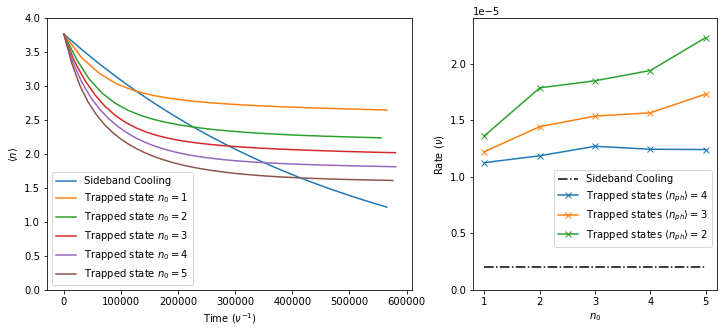

In [68]:
fig, axis = plt.subplots(1,2, figsize=(12,5),gridspec_kw={'width_ratios': [1.5, 1]})


axis[0].set_xlabel(r'Time ($\nu^{-1}$)')
axis[0].set_ylabel(r'$\langle n \rangle$')
axis[0].set_ylim([0,4])

for n0ind in np.arange(1,6):
    Nn0ind=np.loadtxt('Nn0'+str(n0ind)+'.dat')
    if n0ind==1:
        axis[0].plot(Nn0ind[:,0],Nn0ind[:,1],label='Sideband Cooling')
        axis[0].plot(Nn0ind[:,0],Nn0ind[:,2], label= r'Trapped state $n_0=$'+str(n0ind))
    else:
        axis[0].plot(Nn0ind[:,0],Nn0ind[:,1], label= r'Trapped state $n_0=$'+str(n0ind))

#axis.plot(np.arange(0,tmax-1)*dt,np.real(QFIT[0:tmax-1]-0*np.max(QFIT)), label= r'Trapped state $n_0=4$')

#axis.plot(dni*np.arange(0,nimax),0*np.ones(nimax),'k-')
axis[0].legend()

axis[1].set_xlabel(r'$n_0$')
axis[1].set_ylabel(r'Rate ($\nu$)')
axis[1].set_ylim([0,2.4e-5])


axis[1].plot(np.arange(5)+1,1.988324809294638e-06*np.ones(5),'k-.',label = 'Sideband Cooling')

Rates=np.array([[1.1245522240485554e-05,1.1853469251679226e-05,1.2688327605051678e-05,1.2429382168095717e-05,1.2400955108445332e-05],
                [1.2216628011418964e-05,1.4419349410534006e-05,1.5358354171367192e-05,1.564529439692133e-05,1.7302108835923965e-05],
                [1.3610829978421304e-05,1.7848313189815163e-05,1.8476107450584092e-05,1.9381488391292787e-05,2.2291864132054036e-05]])
for i in np.arange(3):
    axis[1].plot(np.arange(5)+1,Rates[i,:], marker='x',label = r'Trapped states $\langle n_{ph}\rangle=$'+str(4-i))

axis[1].legend(loc=7, bbox_to_anchor=(0.5, 0., 0.5, 0.6))
plt.savefig("figure9.pdf", format="pdf", bbox_inches="tight")

plt.show()